In [33]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
def f(x):
  return 3*x**2 - 4*x + 5

In [35]:
f(3.0)

20.0

In [36]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [37]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [38]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [39]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [40]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self helps with the commutative property of multiplication @ 1:15:00
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [41]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [42]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

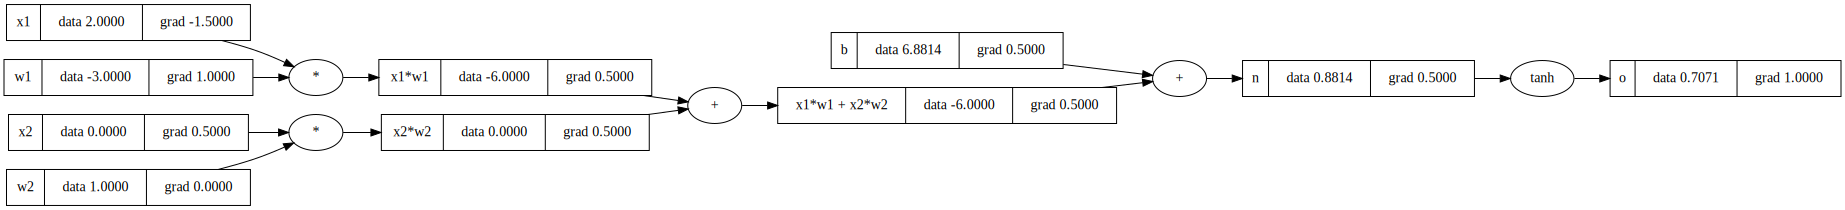

In [43]:
draw_dot(o)

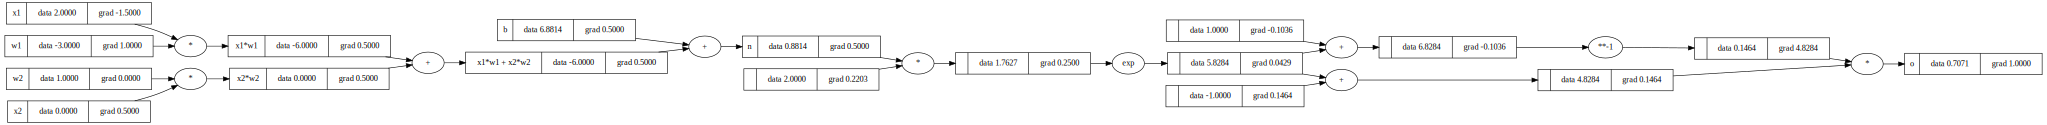

In [52]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [59]:
import torch

In [60]:

# Create input tensors and enable gradient tracking
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
# Create weight tensors and enable gradient tracking  
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
# Create bias tensor and enable gradient tracking
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True

# Compute weighted sum: x1*w1 + x2*w2 + b
n = x1*w1 + x2*w2 + b
# Apply tanh activation function
o = torch.tanh(n)

# Print output value
print(o.data.item())
# Compute gradients through backpropagation
o.backward()

print('---')
# Print gradients for each parameter
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [68]:
class Neuron:
  """A single neuron in a neural network layer.
  
  Implements a neuron with weights, bias and tanh activation function.
  Each neuron takes multiple inputs, multiplies them by learned weights,
  adds a bias term, and applies tanh activation to produce output.
  """
  
  def __init__(self, nin):
    """Initialize a neuron with random weights and bias.
    
    Args:
        nin: Number of inputs to this neuron
    """
    # Initialize weights randomly between -1 and 1
    # Each input needs its own weight to control its influence
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # weights
    # Bias allows shifting the activation function left/right
    self.b = Value(random.uniform(-1,1)) # bias
  
  def __call__(self, x):
    """Forward pass of the neuron.
    
    Args:
        x: Input vector
        
    Returns:
        Output value after applying weights, bias and tanh activation
    """
    # Compute weighted sum: multiply each input by its weight and sum
    # This determines how much each input contributes to the neuron's activation
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # Apply tanh activation to squash output between -1 and 1
    # This adds non-linearity, allowing the network to learn complex patterns
    out = act.tanh()
    return out
  
  def parameters(self):
    """Get all trainable parameters of the neuron.
    These parameters (weights & bias) are adjusted during training to minimize loss.
    
    Returns:
        List of weights and bias
    """
    return self.w + [self.b]

class Layer:
  """A layer of neurons in a neural network.
  Each layer transforms its input by passing it through multiple neurons in parallel.
  This allows the network to learn different features at each layer.
  """
  
  def __init__(self, nin, nout):
    """Initialize a layer with multiple neurons.
    
    Args:
        nin: Number of inputs to each neuron
        nout: Number of neurons in a single layer
    """
    # Create multiple neurons that process the same inputs differently
    # More neurons = more capacity to learn complex patterns
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    """Forward pass of the layer.
    
    Args:
        x: Input vector
        
    Returns:
        Single output if layer has one neuron, list of outputs otherwise
    """
    # Each neuron processes the input independently
    # This creates multiple different transformations of the same input
    outs = [n(x) for n in self.neurons]
    # Simplify output format when only one neuron
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    """Get all trainable parameters of the layer.
    Collects parameters from all neurons for optimization.
    
    Returns:
        Flattened list of all parameters from all neurons
    """
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  """Multi-layer perceptron neural network.
  Stacks multiple layers to learn hierarchical representations.
  Earlier layers learn simple features, later layers combine them into complex patterns.
  """
  
  def __init__(self, nin, nouts):
    """Initialize multi-layer network.
    
    Args:
        nin: Number of inputs to the network
        nouts: List of neuron counts for each layer
    """
    # Calculate sizes for all layers including input
    sz = [nin] + nouts
    # Create sequence of layers with decreasing/increasing sizes
    # Layer sizes determine network capacity and computational cost
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    """Forward pass through the entire network.
    
    Args:
        x: Input vector
        
    Returns:
        Network output after passing through all layers
    """
    # Transform input through successive layers
    # Each layer's output becomes next layer's input
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    """Get all trainable parameters of the network.
    These parameters are optimized during training to minimize the loss function.
    
    Returns:
        Flattened list of all parameters from all layers
    """
    return [p for layer in self.layers for p in layer.parameters()]


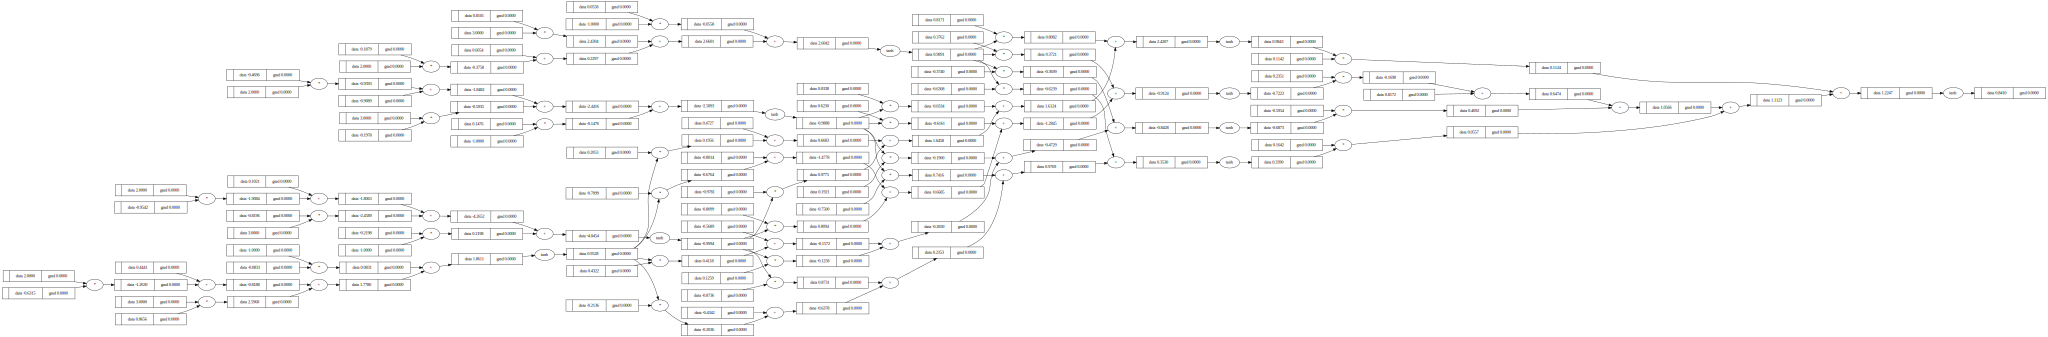

In [63]:
draw_dot(n(x))

In [62]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.8410408398454143)

In [66]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets 
ypred = [n(x) for x in xs]
ypred

[Value(data=0.962823508504414),
 Value(data=-0.9590676908204863),
 Value(data=-0.9423537862135557),
 Value(data=0.9559436297093202)]

In [85]:

# Train the MLP for 20 epochs
for k in range(400):
  
  # Forward pass: Generate predictions for each input sample
  # ypred is a list of network outputs, one for each input vector in xs
  ypred = [n(x) for x in xs]
  # Calculate MSE loss by summing squared differences between predictions and targets
  # ygt = ground truth target value from ys
  # yout = predicted output from ypred
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) 
  
  # Backward pass: Reset gradients to zero before backpropagation
  # p.grad stores the gradient for each parameter
  for p in n.parameters():
    p.grad = 0.0 # reset gradients to zero before computing new ones to prevent the backward pass from accumulating gradients
  
  # Compute gradients through entire network using chain rule
  loss.backward()
  
  # Update parameters using gradient descent
  # -0.1 is the learning rate controlling step size
  # Subtract gradient * learning rate to minimize loss
  for p in n.parameters():
    p.data += -0.1 * p.grad #gradient descent modifies p.data in the direction of the negative gradient
    # we want to minimize the loss function
    # low loss means our predictions are close to the target values
    # you want to tune your learning rate to be just right, if its too high you can overshoot the minimum and if its too low it will take a long time to converge
  # Print epoch number and current loss value to track training
  print(k, loss.data)

  

0 0.0007566854947877026
1 0.0007545269460648551
2 0.0007523804227240018
3 0.0007502458254317345
4 0.0007481230559401705
5 0.0007460120170722491
6 0.0007439126127072026
7 0.0007418247477663262
8 0.00073974832819893
9 0.0007376832609685211
10 0.0007356294540392001
11 0.000733586816362321
12 0.0007315552578633117
13 0.0007295346894287284
14 0.0007275250228935306
15 0.0007255261710284959
16 0.0007235380475279398
17 0.0007215605669975034
18 0.0007195936449422174
19 0.0007176371977547736
20 0.0007156911427038625
21 0.0007137553979228204
22 0.000711829882398383
23 0.0007099145159596369
24 0.00070800921926711
25 0.0007061139138021197
26 0.0007042285218561313
27 0.0007023529665204399
28 0.0007004871716759104
29 0.0006986310619829151
30 0.0006967845628714018
31 0.0006949476005311418
32 0.0006931201019020703
33 0.0006913019946648705
34 0.0006894932072315908
35 0.0006876936687364521
36 0.0006859033090268466
37 0.0006841220586543561
38 0.0006823498488659972
39 0.0006805866115955568
40 0.00067883227

In [86]:
ypred # now we have a model that can predict the target values very closely

[Value(data=0.992392565131997),
 Value(data=-0.9920360834754145),
 Value(data=-0.9882494032456953),
 Value(data=0.9904715800131133)]